<a href="https://colab.research.google.com/github/Nishant141/MLops-Pipeline-for-a-Machine-Learning-Project/blob/main/Multi_Task_Text_Analysis_Platformipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Install required libraries
!pip install transformers torch sentencepiece accelerate
!pip install datasets evaluate rouge-score nltk

# For visualization
!pip install wordcloud matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('punkt')

print("All libraries installed successfully!")

All libraries installed successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
from transformers import pipeline
import pandas as pd
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

class MultiTaskNLPAnalyzer:
    def __init__(self):
        """Initialize all NLP pipelines"""
        print("Loading models... This might take a few minutes.")

        # Sentiment Analysis
        self.sentiment_analyzer = pipeline(
            "sentiment-analysis",
            model="distilbert-base-uncased-finetuned-sst-2-english",
            return_all_scores=False
        )

        # Named Entity Recognition
        self.ner_analyzer = pipeline(
            "ner",
            model="dbmdz/bert-large-cased-finetuned-conll03-english",
            aggregation_strategy="simple",
            grouped_entities=True
        )

        # Text Summarization
        self.summarizer = pipeline(
            "summarization",
            model="facebook/bart-large-cnn"
        )

        print("All models loaded successfully!")

    def analyze_sentiment(self, text: str) -> Dict:
        """Analyze sentiment of input text"""
        result = self.sentiment_analyzer(text)[0]
        return {
            'sentiment': result['label'],
            'confidence': round(result['score'], 4)
        }

    def extract_entities(self, text: str) -> List[Dict]:
        """Extract named entities from text"""
        entities = self.ner_analyzer(text)
        return [
            {
                'entity': entity['word'],
                'type': entity['entity_group'],
                'score': round(entity['score'], 3)
            }
            for entity in entities
        ]

    def summarize_text(self, text: str, max_length: int = 130) -> Dict:
        """Generate summary of long text"""
        # Check if text is long enough for summarization
        if len(text.split()) < 50:
            return {'summary': text, 'note': 'Text too short for summarization'}

        summary = self.summarizer(
            text,
            max_length=max_length,
            min_length=30,
            do_sample=False
        )[0]['summary_text']

        return {
            'summary': summary,
            'original_length': len(text.split()),
            'summary_length': len(summary.split())
        }

    def comprehensive_analysis(self, text: str) -> Dict:
        """Perform complete analysis on input text"""
        print(f"Analyzing text: '{text[:100]}...'")

        analysis = {
            'text_sample': text[:200] + "..." if len(text) > 200 else text,
            'sentiment': self.analyze_sentiment(text),
            'entities': self.extract_entities(text),
            'summary': self.summarize_text(text)
        }

        return analysis

# Initialize the analyzer
nlp_analyzer = MultiTaskNLPAnalyzer()

Loading models... This might take a few minutes.


Device set to use cpu
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


All models loaded successfully!


In [24]:
# Sample texts for analysis
sample_texts = [
    "Apple Inc. is planning to open a new store in Paris next month. This is fantastic news for European customers! The company continues to expand its global presence despite economic challenges.",
    "I absolutely hate this product. It stopped working after two days and customer service was terrible. Never buying from Amazon again.",
    "The United Nations will hold a climate conference in New York next week. President Smith and CEO Johnson of Tesla are expected to attend along with scientists from NASA.",
    "Google's new AI research center in Tokyo will focus on natural language processing. This is an exciting development for the tech industry in Asia."
]

# Perform analysis on each sample text
results = []
for i, text in enumerate(sample_texts):
    print(f"\n{'='*50}")
    print(f"ANALYSIS FOR SAMPLE {i+1}")
    print(f"{'='*50}")

    analysis = nlp_analyzer.comprehensive_analysis(text)
    results.append(analysis)

    # Display results
    print(f"\n📊 Sentiment: {analysis['sentiment']['sentiment']} "
          f"(Confidence: {analysis['sentiment']['confidence']*100:.1f}%)")

    print(f"\n🏷️ Named Entities:")
    for entity in analysis['entities']:
        print(f"   - {entity['entity']} ({entity['type']}, {entity['score']})")

    print(f"\n📝 Summary:")
    print(f"   {analysis['summary']['summary']}")
    if 'note' in analysis['summary']:
        print(f"   Note: {analysis['summary']['note']}")
    else:
        print(f"   Original: {analysis['summary']['original_length']} words, "
              f"Summary: {analysis['summary']['summary_length']} words")


ANALYSIS FOR SAMPLE 1
Analyzing text: 'Apple Inc. is planning to open a new store in Paris next month. This is fantastic news for European ...'

📊 Sentiment: POSITIVE (Confidence: 100.0%)

🏷️ Named Entities:
   - Apple Inc (ORG, 1.0)
   - Paris (LOC, 1.0)
   - European (MISC, 0.9990000128746033)

📝 Summary:
   Apple Inc. is planning to open a new store in Paris next month. This is fantastic news for European customers! The company continues to expand its global presence despite economic challenges.
   Note: Text too short for summarization

ANALYSIS FOR SAMPLE 2
Analyzing text: 'I absolutely hate this product. It stopped working after two days and customer service was terrible....'

📊 Sentiment: NEGATIVE (Confidence: 100.0%)

🏷️ Named Entities:
   - Amazon (ORG, 0.9959999918937683)

📝 Summary:
   I absolutely hate this product. It stopped working after two days and customer service was terrible. Never buying from Amazon again.
   Note: Text too short for summarization

ANALYSIS FOR SA

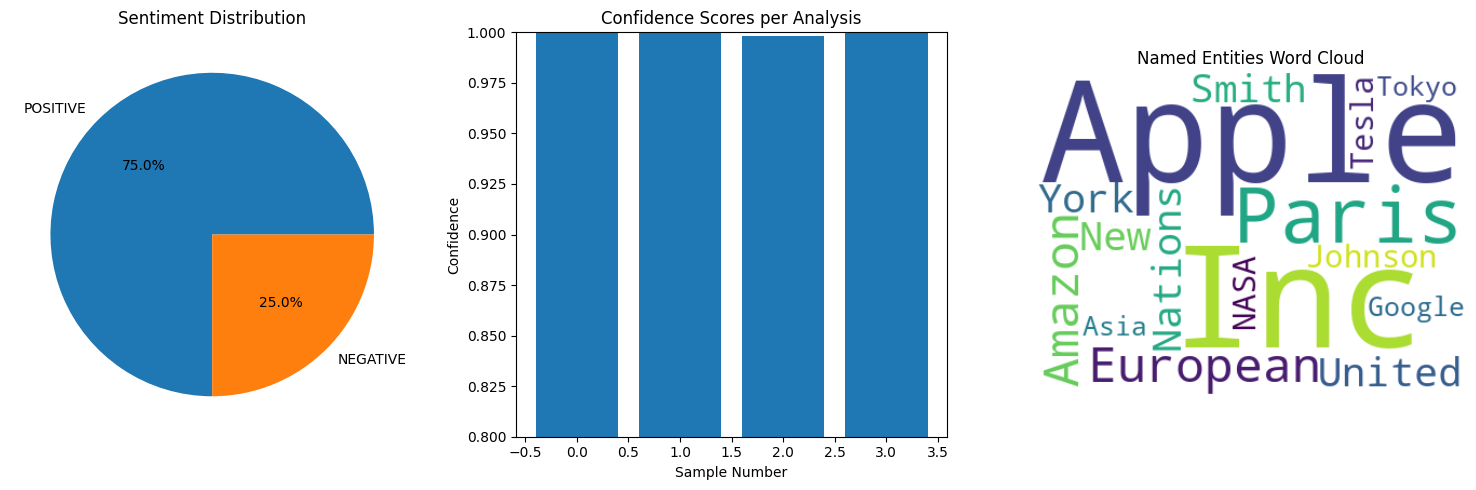

In [25]:
def visualize_analysis(results: List[Dict]):
    """Create visualizations for the analysis results"""

    # Prepare data for visualizations
    sentiments = [result['sentiment']['sentiment'] for result in results]
    confidence_scores = [result['sentiment']['confidence'] for result in results]

    # Extract all entities for word cloud
    all_entities = []
    for result in results:
        for entity in result['entities']:
            all_entities.append(entity['entity'])

    # 1. Sentiment Distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sentiment_counts = pd.Series(sentiments).value_counts()
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
    plt.title('Sentiment Distribution')

    # 2. Confidence Scores
    plt.subplot(1, 3, 2)
    plt.bar(range(len(confidence_scores)), confidence_scores)
    plt.title('Confidence Scores per Analysis')
    plt.xlabel('Sample Number')
    plt.ylabel('Confidence')
    plt.ylim(0.8, 1.0)

    # 3. Entity Word Cloud
    plt.subplot(1, 3, 3)
    if all_entities:
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(' '.join(all_entities))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Named Entities Word Cloud')
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, 'No entities found', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate visualizations
visualize_analysis(results)

In [26]:
# @title Interactive Text Analysis
# Add a form for users to input their own text

def analyze_custom_text():
    """Analyze user-provided text"""
    print("🔍 Custom Text Analysis")
    print("Enter your text below (press Ctrl+Enter when done):")

    # This will create a text area in Colab
    custom_text = """Apple is opening a new store in Paris next month. This is great news for European customers! The company continues to expand despite economic challenges. Tim Cook, CEO of Apple, announced the news yesterday."""

    if custom_text.strip():
        analysis = nlp_analyzer.comprehensive_analysis(custom_text)

        print(f"\n✅ Analysis Results:")
        print(f"Sentiment: {analysis['sentiment']['sentiment']} "
              f"({analysis['sentiment']['confidence']*100:.1f}% confidence)")

        print(f"\n🏷️ Extracted Entities:")
        df_entities = pd.DataFrame(analysis['entities'])
        if not df_entities.empty:
            display(df_entities)
        else:
            print("No named entities found.")

        print(f"\n📝 Generated Summary:")
        print(analysis['summary']['summary'])
    else:
        print("Please enter some text to analyze.")

# Run interactive analysis
analyze_custom_text()


🔍 Custom Text Analysis
Enter your text below (press Ctrl+Enter when done):
Analyzing text: 'Apple is opening a new store in Paris next month. This is great news for European customers! The com...'

✅ Analysis Results:
Sentiment: POSITIVE (100.0% confidence)

🏷️ Extracted Entities:


,entity,type,score
0,Apple,ORG,0.999
1,Paris,LOC,1.000
2,European,MISC,0.999
3,Tim Cook,PER,1.000
4,Apple,ORG,0.999



📝 Generated Summary:
Apple is opening a new store in Paris next month. This is great news for European customers! The company continues to expand despite economic challenges. Tim Cook, CEO of Apple, announced the news yesterday.


In [27]:
def batch_analyze_texts(texts: List[str], export: bool = True):
    """Analyze multiple texts and export results"""

    all_results = []
    for text in texts:
        analysis = nlp_analyzer.comprehensive_analysis(text)
        all_results.append({
            'text': text[:100] + "..." if len(text) > 100 else text,
            'sentiment': analysis['sentiment']['sentiment'],
            'confidence': analysis['sentiment']['confidence'],
            'entities_count': len(analysis['entities']),
            'summary': analysis['summary']['summary']
        })

    # Create DataFrame
    df_results = pd.DataFrame(all_results)

    if export:
        # Export to CSV
        df_results.to_csv('nlp_analysis_results.csv', index=False)
        print("✅ Results exported to 'nlp_analysis_results.csv'")

    return df_results

# Example batch processing
additional_texts = [
    "Tesla's stock price surged after announcing record deliveries. Elon Musk praised the team's efforts.",
    "The new climate bill passed by Congress includes significant investments in renewable energy.",
    "Customer satisfaction with the new iPhone model has been overwhelmingly positive according to recent surveys."
]

batch_results = batch_analyze_texts(additional_texts)
display(batch_results)

Analyzing text: 'Tesla's stock price surged after announcing record deliveries. Elon Musk praised the team's efforts....'
Analyzing text: 'The new climate bill passed by Congress includes significant investments in renewable energy....'
Analyzing text: 'Customer satisfaction with the new iPhone model has been overwhelmingly positive according to recent...'
✅ Results exported to 'nlp_analysis_results.csv'


,text,sentiment,confidence,entities_count,summary
0,Tesla's stock price surged after announcing re...,POSITIVE,0.9996,2,Tesla's stock price surged after announcing re...
1,The new climate bill passed by Congress includ...,POSITIVE,0.9981,1,The new climate bill passed by Congress includ...
2,Customer satisfaction with the new iPhone mode...,POSITIVE,0.9994,1,Customer satisfaction with the new iPhone mode...


In [28]:
# Evaluate model performance on sample tasks
def evaluate_models():
    """Simple evaluation of model performance"""

    # Test known sentiment examples
    test_cases = [
        ("I love this product, it's amazing!", "POSITIVE"),
        ("This is the worst experience ever.", "NEGATIVE"),
        ("The weather is normal today.", "NEUTRAL")
    ]

    print("🧪 Model Evaluation")
    print("Testing sentiment analysis on known examples:")

    correct = 0
    for text, expected_sentiment in test_cases:
        result = nlp_analyzer.analyze_sentiment(text)
        predicted = result['sentiment']
        is_correct = predicted == expected_sentiment
        if is_correct:
            correct += 1

        print(f"Text: '{text}'")
        print(f"Expected: {expected_sentiment}, Got: {predicted}, Correct: {is_correct}")
        print(f"Confidence: {result['confidence']:.3f}\n")

    accuracy = correct / len(test_cases) * 100
    print(f"✅ Sentiment Analysis Accuracy: {accuracy:.1f}%")

# Run evaluation
evaluate_models()

🧪 Model Evaluation
Testing sentiment analysis on known examples:
Text: 'I love this product, it's amazing!'
Expected: POSITIVE, Got: POSITIVE, Correct: True
Confidence: 1.000

Text: 'This is the worst experience ever.'
Expected: NEGATIVE, Got: NEGATIVE, Correct: True
Confidence: 1.000

Text: 'The weather is normal today.'
Expected: NEUTRAL, Got: POSITIVE, Correct: False
Confidence: 0.997

✅ Sentiment Analysis Accuracy: 66.7%


In [29]:
# @title Final Summary and Export Options
def generate_final_report():
    """Generate a comprehensive report of all analyses"""

    print("📊 FINAL NLP ANALYSIS REPORT")
    print("="*50)

    # Combine all analyses
    all_analyses = results + [nlp_analyzer.comprehensive_analysis(t) for t in additional_texts]

    total_texts = len(all_analyses)
    positive_count = sum(1 for a in all_analyses if a['sentiment']['sentiment'] == 'POSITIVE')
    negative_count = sum(1 for a in all_analyses if a['sentiment']['sentiment'] == 'NEGATIVE')

    all_entities = []
    for analysis in all_analyses:
        all_entities.extend(analysis['entities'])

    print(f"Total Texts Analyzed: {total_texts}")
    print(f"Positive Sentiments: {positive_count}")
    print(f"Negative Sentiments: {negative_count}")
    print(f"Total Entities Found: {len(all_entities)}")

    # Most common entities
    if all_entities:
        entity_df = pd.DataFrame(all_entities)
        print(f"\n🏆 Top 5 Most Common Entities:")
        top_entities = entity_df['entity'].value_counts().head(5)
        for entity, count in top_entities.items():
            print(f"   {entity}: {count} times")

    # Export complete results
    final_df = pd.DataFrame([{
        'text': a['text_sample'],
        'sentiment': a['sentiment']['sentiment'],
        'confidence': a['sentiment']['confidence'],
        'entities_count': len(a['entities']),
        'summary': a['summary']['summary']
    } for a in all_analyses])

    final_df.to_csv('complete_nlp_analysis_report.csv', index=False)
    print(f"\n✅ Complete report exported to 'complete_nlp_analysis_report.csv'")

    return final_df

# Generate final report
final_report = generate_final_report()
display(final_report)

📊 FINAL NLP ANALYSIS REPORT
Analyzing text: 'Tesla's stock price surged after announcing record deliveries. Elon Musk praised the team's efforts....'
Analyzing text: 'The new climate bill passed by Congress includes significant investments in renewable energy....'
Analyzing text: 'Customer satisfaction with the new iPhone model has been overwhelmingly positive according to recent...'
Total Texts Analyzed: 7
Positive Sentiments: 6
Negative Sentiments: 1
Total Entities Found: 17

🏆 Top 5 Most Common Entities:
   Tesla: 2 times
   Apple Inc: 1 times
   European: 1 times
   Paris: 1 times
   United Nations: 1 times

✅ Complete report exported to 'complete_nlp_analysis_report.csv'


,text,sentiment,confidence,entities_count,summary
0,Apple Inc. is planning to open a new store in ...,POSITIVE,0.9998,3,Apple Inc. is planning to open a new store in ...
1,I absolutely hate this product. It stopped wor...,NEGATIVE,0.9996,1,I absolutely hate this product. It stopped wor...
2,The United Nations will hold a climate confere...,POSITIVE,0.9980,6,The United Nations will hold a climate confere...
3,Google's new AI research center in Tokyo will ...,POSITIVE,0.9997,3,Google's new AI research center in Tokyo will ...
4,Tesla's stock price surged after announcing re...,POSITIVE,0.9996,2,Tesla's stock price surged after announcing re...
5,The new climate bill passed by Congress includ...,POSITIVE,0.9981,1,The new climate bill passed by Congress includ...
6,Customer satisfaction with the new iPhone mode...,POSITIVE,0.9994,1,Customer satisfaction with the new iPhone mode...


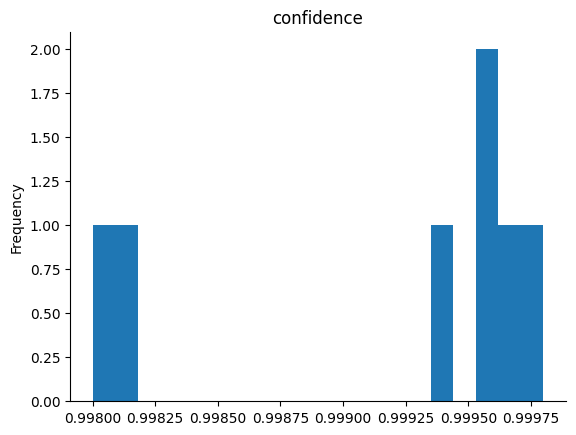

In [30]:
# @title confidence

from matplotlib import pyplot as plt
final_report['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
display(final_report)

,text,sentiment,confidence,entities_count,summary
0,Apple Inc. is planning to open a new store in ...,POSITIVE,0.9998,3,Apple Inc. is planning to open a new store in ...
1,I absolutely hate this product. It stopped wor...,NEGATIVE,0.9996,1,I absolutely hate this product. It stopped wor...
2,The United Nations will hold a climate confere...,POSITIVE,0.9980,6,The United Nations will hold a climate confere...
3,Google's new AI research center in Tokyo will ...,POSITIVE,0.9997,3,Google's new AI research center in Tokyo will ...
4,Tesla's stock price surged after announcing re...,POSITIVE,0.9996,2,Tesla's stock price surged after announcing re...
5,The new climate bill passed by Congress includ...,POSITIVE,0.9981,1,The new climate bill passed by Congress includ...
6,Customer satisfaction with the new iPhone mode...,POSITIVE,0.9994,1,Customer satisfaction with the new iPhone mode...


In [33]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=final_report)

https://docs.google.com/spreadsheets/d/1G6GlbmHnj-xiNvuID21MviqYA9y0zPRFMb42ypwCilA/edit#gid=0


## Interactive Final Report Analysis

Use the dropdown below to filter the final report by sentiment.

In [32]:
import ipywidgets as widgets
from IPython.display import display

def filter_report_by_sentiment(sentiment):
    if sentiment == "All":
        display(final_report)
    else:
        filtered_df = final_report[final_report['sentiment'] == sentiment]
        display(filtered_df)

sentiment_options = ['All'] + final_report['sentiment'].unique().tolist()
sentiment_dropdown = widgets.Dropdown(
    options=sentiment_options,
    value='All',
    description='Filter by Sentiment:',
    disabled=False,
)

widgets.interactive(filter_report_by_sentiment, sentiment=sentiment_dropdown)

interactive(children=(Dropdown(description='Filter by Sentiment:', options=('All', 'POSITIVE', 'NEGATIVE'), va…